In [89]:
import pandas as pd
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessário para o plot 3D
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Preparação da Base para Análise

In [90]:
# --- Definição dos Caminhos & Importação de Dados ---
path_raw_data = "../../data/processed/Processed_JODI.csv"
path_imgs = "../../report/img/"

# Base Principal
jodi_dataset = pd.read_csv(path_raw_data)

# --- Limpeza de Dados ---
jodi_dataset['TIME_PERIOD'] = pd.to_datetime(jodi_dataset['TIME_PERIOD'])

jodi_dataset = jodi_dataset.pivot_table(
        index='TIME_PERIOD',
        columns=['ENERGY_PRODUCT', 'FLOW_BREAKDOWN'],
        values='OBS_VALUE'
    ).reset_index()

# Ajustes Finais
jodi_dataset.columns = ['_'.join(col).strip() for col in jodi_dataset.columns.values]
jodi_dataset.rename(columns={'TIME_PERIOD_': 'TIME_PERIOD'}, inplace=True)

# Variáveis estão em Kbpd, aqui vou transformar por milhão para faciltiar compreensão dos dados.
jodi_dataset.iloc[:, 1:] = jodi_dataset.iloc[:, 1:] / 1000

# Criando uma nova base para acoplar as previsões
jodi_dataset_predictions = jodi_dataset.copy()


## Regressão Linear

```math
CRUDEOIL\_REFINOBS = \beta_0 + \beta_1 \times GASOLINE\_TOTDEMO + \beta_2 \times GASDIES\_TOTDEMO + \varepsilon
```

In [91]:
# Regressão Linear para Demanda de Refinarias

# Neste modelo, vamos realizar uma regressão tendo como variável dependente a CRUDEOIL_REFINOBS, 
# que representa a demanda por petróleo das refinarias americanas. As variáveis explicativas serão a demanda total de gasolina e a demanda total de diesel, 
# escolhidas por representarem aproximadamente 80% do volume processado em uma refinaria.

# Definir a variável dependente (y) e as independentes (X)
y = jodi_dataset['CRUDEOIL_REFINOBS']
X = jodi_dataset[['GASDIES_TOTDEMO', 'GASOLINE_TOTDEMO']]

# Adicionar uma constante (intercepto) ao modelo
X = sm.add_constant(X)

# Rodar a regressão
modelo = sm.OLS(y, X).fit()

# Exibir o resumo dos resultados
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:      CRUDEOIL_REFINOBS   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     80.55
Date:                Thu, 19 Jun 2025   Prob (F-statistic):           2.79e-28
Time:                        12:42:46   Log-Likelihood:                -310.36
No. Observations:                 279   AIC:                             626.7
Df Residuals:                     276   BIC:                             637.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.3203      1.167  

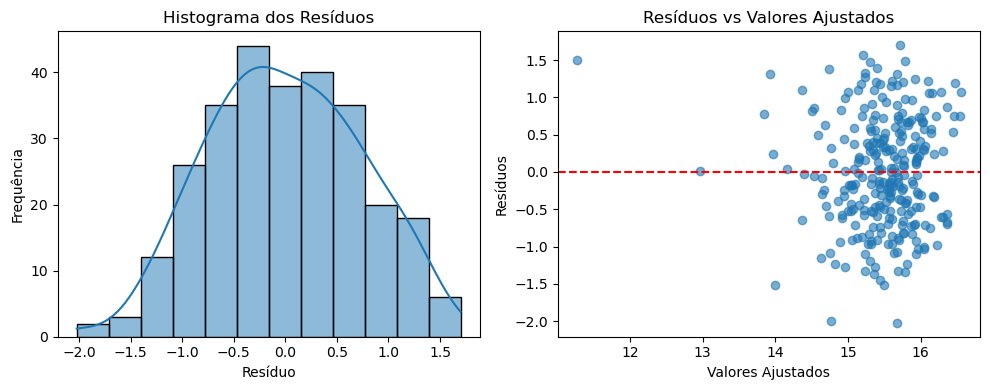

In [92]:
# Resíduos do modelo
residuos = modelo.resid

# Gráfico 1: Histograma dos resíduos
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')
plt.xlabel('Resíduo')
plt.ylabel('Frequência')

# Gráfico 2: Resíduos vs Valores Ajustados
plt.subplot(1,2,2)
plt.scatter(modelo.fittedvalues, residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')

plt.tight_layout()
plt.show()

Calcular os resíduos de um modelo de regressão serve para avaliar a qualidade do ajuste do modelo e verificar se ele atende às principais suposições da regressão linear, como normalidade, homocedasticidade e linearidade. Os resíduos representam a diferença entre os valores observados e os valores previstos pelo modelo — ou seja, indicam o quanto o modelo está errando.

No histograma dos resíduos, observamos uma distribuição simétrica e próxima da forma de sino, o que sugere que os erros seguem uma distribuição aproximadamente normal, atendendo a uma das premissas do modelo OLS. Já o gráfico de resíduos versus valores ajustados mostrou que os resíduos estão dispersos aleatoriamente em torno da linha zero, sem apresentar padrões ou variações sistemáticas. Isso indica que a variância dos erros é aproximadamente constante (homocedasticidade) e que a relação entre as variáveis do modelo parece ser linear. Ambos os gráficos, portanto, sugerem que o modelo está bem especificado e que as premissas básicas da regressão linear estão sendo respeitadas.

In [93]:
# Coeficientes do modelo
intercepto = modelo.params['const']
coef_gasdies = modelo.params['GASDIES_TOTDEMO']
coef_gasoline = modelo.params['GASOLINE_TOTDEMO']

# Última observação dos dados para variáveis independentes
ultimo_gasdies = jodi_dataset['GASDIES_TOTDEMO'].iloc[-1]
ultimo_gasoline = jodi_dataset['GASOLINE_TOTDEMO'].iloc[-1]

# Última observação real da variável dependente (refinarias)
ultimo_real = jodi_dataset['CRUDEOIL_REFINOBS'].iloc[-1]

# Função para projetar demanda de petróleo (modelo)
def projetar_petróleo(gasdies, gasoline):
    return intercepto + coef_gasdies * gasdies + coef_gasoline * gasoline

# Cenário base (última observação projetada pelo modelo)
base = projetar_petróleo(ultimo_gasdies, ultimo_gasoline)

# Cenários simulados
cenario1 = projetar_petróleo(ultimo_gasdies, ultimo_gasoline * 1.10)
cenario2 = projetar_petróleo(ultimo_gasdies, ultimo_gasoline * 1.50)
cenario3 = projetar_petróleo(ultimo_gasdies * 1.10, ultimo_gasoline)
cenario4 = projetar_petróleo(ultimo_gasdies * 1.50, ultimo_gasoline)
cenario5 = projetar_petróleo(ultimo_gasdies * 1.25, ultimo_gasoline * 1.25)

# Criar DataFrame com resultados
resultados = pd.DataFrame({
    "Cenário": [
        "Demanda atual (última obs)",
        "Cenário 1 (+10% gasolina)",
        "Cenário 2 (+50% gasolina)",
        "Cenário 3 (+10% diesel)",
        "Cenário 4 (+50% diesel)",
        "Cenário 5 (+25% diesel e gasolina)"
    ],
    "Demanda Projetada": [
        base,
        cenario1,
        cenario2,
        cenario3,
        cenario4,
        cenario5
    ]
})

# Calcular o aumento projetado em relação à base projetada
resultados["Aumento vs Base"] = resultados["Demanda Projetada"] - base

# Valor base real fixo (último valor real da demanda nas refinarias)
resultados["Valor Base Real"] = jodi_dataset['CRUDEOIL_REFINOBS'].iloc[-1]

# Valor total = último valor real + aumento projetado
resultados["Valor Total"] = resultados["Valor Base Real"] + resultados["Aumento vs Base"]

# Formatar números para melhor visualização
for col in ["Demanda Projetada", "Aumento vs Base", "Valor Base Real", "Valor Total"]:
    resultados[col] = resultados[col].map(lambda x: f"{x:,.2f}")

# Mostrar a tabela formatada
resultados


,Cenário,Demanda Projetada,Aumento vs Base,Valor Base Real,Valor Total
0,Demanda atual (última obs),15.96,0.00,15.66,15.66
1,Cenário 1 (+10% gasolina),17.17,1.21,15.66,16.87
2,Cenário 2 (+50% gasolina),22.01,6.05,15.66,21.72
3,Cenário 3 (+10% diesel),16.11,0.15,15.66,15.82
4,Cenário 4 (+50% diesel),16.73,0.77,15.66,16.43
5,Cenário 5 (+25% diesel e gasolina),19.37,3.41,15.66,19.07


### Objetivo da tabela

Utilizei os coeficientes da regressão linear para projetar a demanda de petróleo bruto em refinarias sob diferentes cenários de aumento na demanda por gasolina e diesel.

- **Demanda Projetada:** valor estimado da demanda em cada cenário.

- **Aumento vs Base:** quanto a demanda projetada cresce em relação ao cenário atual (última observação).

- **Valor Base Real:** valor real observado mais recente da demanda nas refinarias.

- **Valor Total:** simula o efeito total sobre a demanda real caso os aumentos na demanda por gasolina e/ou diesel realmente ocorram.

### Resultados

- **Cenário 1 (+10% gasolina):** aumenta 1.2 milhões de barris/dia na demanda projetada.

- **Cenário 2 (+50% gasolina):** impacto mais forte (↑ 6.1), refletindo o maior coeficiente da variável gasolina no modelo.

- **Cenário 4 (+50% diesel):** impacto menor (↑ 0.8), pois o coeficiente da variável diesel é mais baixo.

- **Cenário 5 (+25% gasolina e diesel):** aumento total de 3.4 — efeito combinado dos dois produtos.

De acordo com os resultados, o modelo indica que a demanda por gasolina tem um impacto maior na quantidade de petróleo processado nas refinarias do que a demanda por diesel, o que está de acordo com os coeficientes da regressão (gasolina ≈ 1.28, diesel ≈ 0.40) ( a cada 1 milhão de barris de gasolina/dia, aumenta a demanda em 1.2 milhões a demanda por petróleo/dia. A cada 1 milhão de barris de diesel/dia, aumenta a demanda em 400 mil barris de petróleo/dia). 
A simulação mostra de forma clara como variações na demanda por derivados podem afetar a operação das refinarias.

## Modelos de Séries Temporais


### Diesel - Arima

```math
(1 - \phi_1 L - \phi_2 L^2 - \ldots - \phi_p L^p) \nabla^d y_t = (1 + \theta_1 L + \theta_2 L^2 + \ldots + \theta_q L^q) \epsilon_t
```

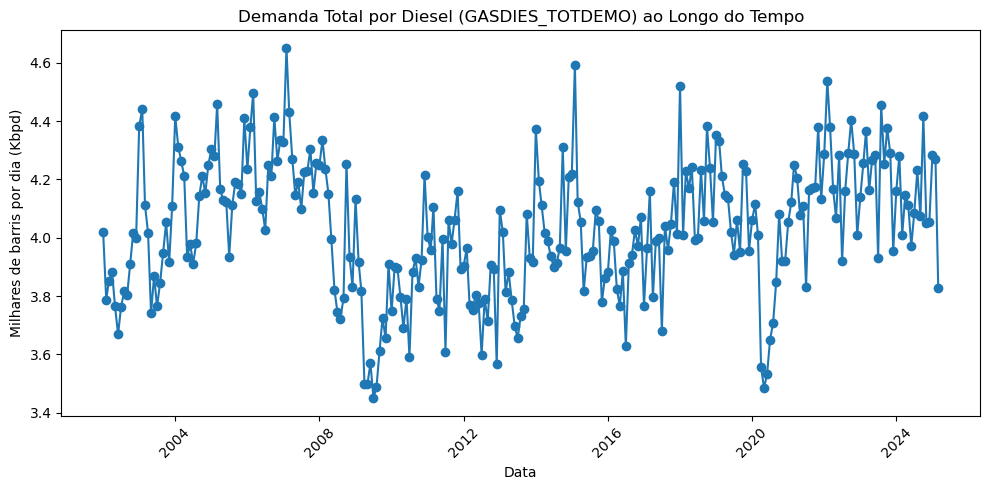

In [94]:
## Diesel Arima

### Obs: Diesel também tem sazonalidade, mas menos evidente que a gasolina, sendo assim, para efeitos de simplicaficação e comparação eu vou ignorar esse fator na análise

# Análise Histórica dos dados
plt.figure(figsize=(10, 5))
plt.plot(jodi_dataset['TIME_PERIOD'], jodi_dataset['GASDIES_TOTDEMO'], marker='o', linestyle='-')
plt.title('Demanda Total por Diesel (GASDIES_TOTDEMO) ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Milhares de barris por dia (Kbpd)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [95]:
result = adfuller(jodi_dataset['GASDIES_TOTDEMO'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## Dados são Estacionários p-value < 0.05

ADF Statistic: -3.1946328962725756
p-value: 0.020297457769406883


In [96]:
# Escolhendo o melhor modelo ARIMA automaticamente
modelo_auto = auto_arima(jodi_dataset['GASDIES_TOTDEMO'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(modelo_auto.summary())

Performing stepwise search to minimize aic


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1572.857, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1215.800, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-175.131, Time=0.04 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-180.606, Time=0.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-172.347, Time=0.29 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-175.670, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-179.623, Time=0.43 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-196.605, Time=0.35 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-197.983, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-119.967, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-182.180, Time=0.10 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-197.235, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-26.989, Time=0.04 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-145.750, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-197.020, Time=0.13 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-194.373, Time=0.39 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 3.952 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  279
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 102.992
Date:                Thu, 19 Jun 2025   AIC                           -197.983
Time:                        12:42:51   BIC                           -183.459
Sample:                             0   HQIC                          -192.157
                                - 279                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6135      0.204      3.003      0.003       0.213 

In [97]:
# Ajuste manual (substitua os parâmetros conforme o resultado do auto_arima)
modelo_arima = ARIMA(jodi_dataset['GASDIES_TOTDEMO'], order=(1, 1, 1))
resultado_arima = modelo_arima.fit()
print(resultado_arima.summary())

                               SARIMAX Results                                
Dep. Variable:        GASDIES_TOTDEMO   No. Observations:                  279
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  97.187
Date:                Thu, 19 Jun 2025   AIC                           -188.373
Time:                        12:42:52   BIC                           -177.491
Sample:                             0   HQIC                          -184.007
                                - 279                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3848      0.091      4.233      0.000       0.207       0.563
ma.L1         -0.8392      0.055    -15.335      0.000      -0.946      -0.732
sigma2         0.0290      0.002     12.392      0.0

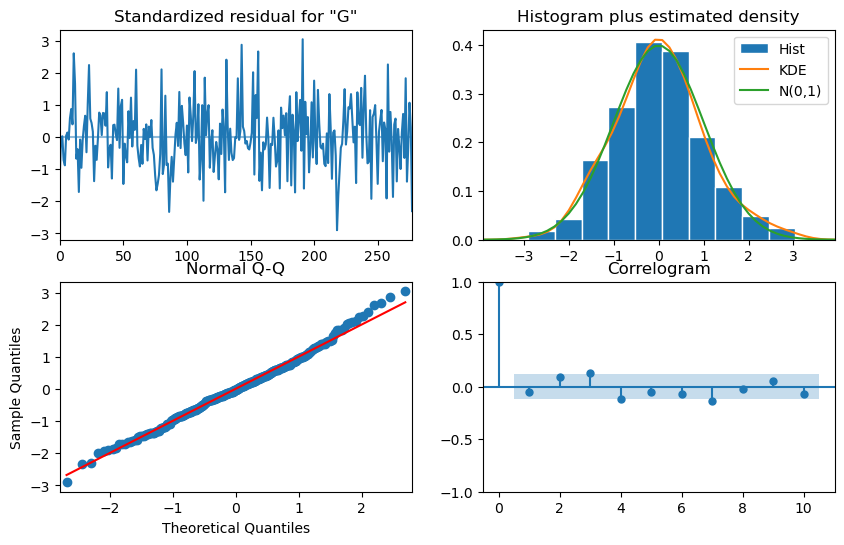

In [98]:
resultado_arima.plot_diagnostics(figsize=(10, 6))
plt.show()

Esses gráficos servem para verificar se o modelo ajustado é adequado, isto é, se os resíduos se comportam como um ruído branco (sem estrutura temporal, média zero, variância constante e distribuição normal).

1. Resíduos padronizados (gráfico superior esquerdo)
Os resíduos estão distribuídos de forma aparentemente aleatória ao redor de zero, sem padrão visível → bom sinal, indica que o modelo está capturando bem a estrutura da série.

2. Histograma + Densidade (superior direito)
A curva do histograma dos resíduos se sobrepõe bem à curva normal padrão (verde), sugerindo que os resíduos têm distribuição aproximadamente normal, o que é desejado.

3. Gráfico Q-Q (inferior esquerdo)
Os pontos estão alinhados à reta vermelha, especialmente no centro, o que reforça a normalidade dos resíduos. Pequenos desvios nas caudas são aceitáveis.

4. Correlograma dos resíduos (inferior direito)
A maioria dos pontos está dentro das faixas de confiança (zonas azuis) → não há autocorrelação significativa nos resíduos, o que é crucial para um modelo ARIMA bem ajustado.

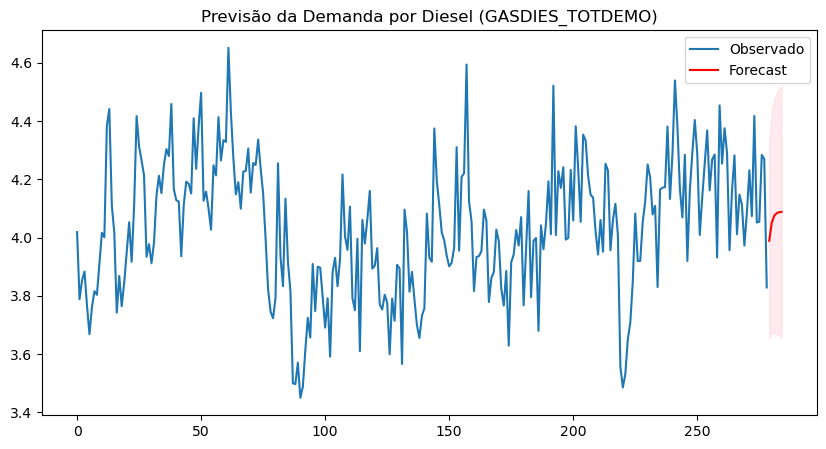

In [99]:
forecast = resultado_arima.get_forecast(steps=6)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(jodi_dataset.index, jodi_dataset['GASDIES_TOTDEMO'], label='Observado')
plt.plot(pred.index, pred, label='Forecast', color='red')
plt.fill_between(pred.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Previsão da Demanda por Diesel (GASDIES_TOTDEMO)')
plt.legend()
plt.show()

In [100]:
# Criar DataFrame com as previsões
tabela_forecast = pd.DataFrame({
    "Data Prevista": pred.index,
    "Demanda Projetada (Mbpd)": pred.values,
    "IC Inferior (Mbpd)": conf_int.iloc[:, 0].values,
    "IC Superior (Mbpd)": conf_int.iloc[:, 1].values
})

# Formatar os valores para 2 casas decimais e separador de milhar
tabela_forecast["Demanda Projetada (Mbpd)"] = tabela_forecast["Demanda Projetada (Mbpd)"].map(lambda x: f"{x:,.2f}")
tabela_forecast["IC Inferior (Mbpd)"] = tabela_forecast["IC Inferior (Mbpd)"].map(lambda x: f"{x:,.2f}")
tabela_forecast["IC Superior (Mbpd)"] = tabela_forecast["IC Superior (Mbpd)"].map(lambda x: f"{x:,.2f}")


# Preparar para Concatenar na Base Original
temp_dt_arima = tabela_forecast.copy()

temp_dt_arima.rename(columns={'Data Prevista': 'TIME_PERIOD', "Demanda Projetada (Mbpd)":"GASDIES_TOTDEMO"}, inplace=True)
temp_dt_arima['TIME_PERIOD'] = [
    '2025-04-01',
    '2025-05-01',
    '2025-06-01',
    '2025-07-01',
    '2025-08-01',
    '2025-09-01'
]

temp_dt_arima = temp_dt_arima[["TIME_PERIOD", "GASDIES_TOTDEMO"]]
temp_dt_arima["TIME_PERIOD"] = pd.to_datetime(temp_dt_arima["TIME_PERIOD"])

# Exibir a tabela
tabela_forecast

,Data Prevista,Demanda Projetada (Mbpd),IC Inferior (Mbpd),IC Superior (Mbpd)
0,279,3.99,3.65,4.32
1,280,4.05,3.67,4.43
2,281,4.07,3.67,4.47
3,282,4.08,3.67,4.50
4,283,4.09,3.66,4.51
5,284,4.09,3.66,4.52


### Gasolina - Sarima

```math
\Phi_P(L^s) \cdot \phi_p(L) \cdot \nabla^d \nabla_s^D y_t = \Theta_Q(L^s) \cdot \theta_q(L) \cdot \epsilon_t
```

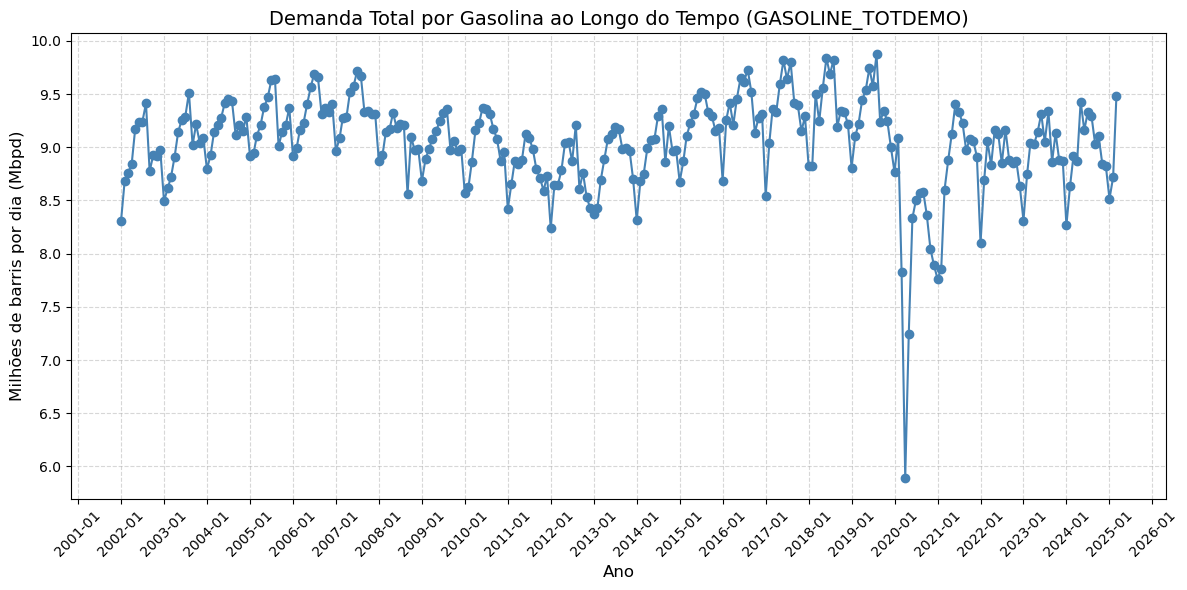

In [101]:
## Gasoline Sarima

### Obs: Forte efeito sazonal por conta da driving season nos EUA

# Converter a coluna 'TIME_PERIOD' para datetime (caso ainda não esteja)
jodi_dataset['TIME_PERIOD'] = pd.to_datetime(jodi_dataset['TIME_PERIOD'])

# Ajustar o índice para ser o tempo (opcional, mas ajuda em gráficos futuros)
jodi_dataset.set_index('TIME_PERIOD', inplace=True)

# Plotagem da série histórica
plt.figure(figsize=(12, 6))
plt.plot(jodi_dataset.index, jodi_dataset['GASOLINE_TOTDEMO'], marker='o', linestyle='-', color='steelblue')

plt.title('Demanda Total por Gasolina ao Longo do Tempo (GASOLINE_TOTDEMO)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Milhões de barris por dia (Mbpd)', fontsize=12)

# Melhorar o eixo X para mostrar anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [102]:
# Teste de Estacionariedade (ADF) para a série de Diesel
result = adfuller(jodi_dataset['GASOLINE_TOTDEMO'].dropna())

print(f"Estatística ADF: {result[0]:.4f}")
print(f"Valor-p: {result[1]:.4f}")

if result[1] < 0.05:
    print("Conclusão: A série é estacionária (p-valor < 0.05).")
else:
    print("Conclusão: A série não é estacionária (p-valor >= 0.05).")

Estatística ADF: -2.9698
Valor-p: 0.0378
Conclusão: A série é estacionária (p-valor < 0.05).


In [103]:
# Ajuste automático do modelo SARIMA considerando sazonalidade (exemplo sazonalidade mensal = 12)
modelo_sarima = auto_arima(
    jodi_dataset['GASOLINE_TOTDEMO'], 
    seasonal=True,       # ativa sazonalidade
    m=12,                # período sazonal (12 meses)
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True,
    stepwise=True
)

print(modelo_sarima.summary())

Performing stepwise search to minimize aic


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=322.231, Time=0.08 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.65 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=147.938, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2023.196, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=181.094, Time=0.17 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=169.794, Time=1.31 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=129.656, Time=0.63 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=3.46 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=277.987, Time=0.44 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=65.494, Time=1.21 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=82.849, Time=0.57 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=6.391, Time=1.79 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.02 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=11.511, Time=2.49 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=nan sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.53 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=2.32 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.05 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.44 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,2)[12] intercept   : AIC=86.290, Time=2.11 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.67 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.12 sec


c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[12]             : AIC=inf, Time=1.17 sec

Best model:  ARIMA(1,0,1)(1,0,2)[12] intercept
Total fit time: 31.386 seconds
                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  279
Model:             SARIMAX(1, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                   3.804
Date:                                 Thu, 19 Jun 2025   AIC                              6.391
Time:                                         12:43:25   BIC                             31.810
Sample:                                     01-01-2002   HQIC                            16.588
                                          - 03-01-2025                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

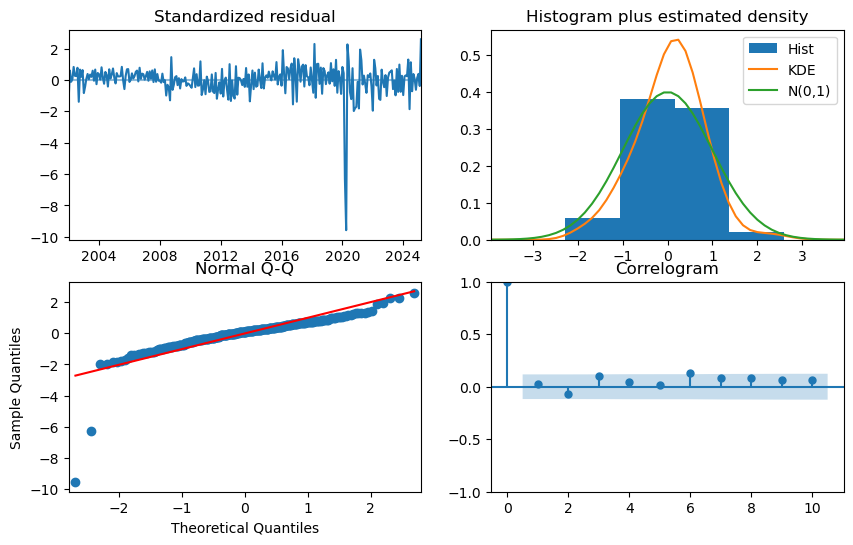

In [104]:
modelo_sarima.plot_diagnostics(figsize=(10, 6))
plt.show()

A interpretação aqui segue na mesma linha que a do Arima-Diesel. 

Esses gráficos servem para verificar se o modelo ajustado é adequado, isto é, se os resíduos se comportam como um ruído branco (sem estrutura temporal, média zero, variância constante e distribuição normal).

1. Resíduos padronizados (gráfico superior esquerdo)
Os resíduos estão distribuídos de forma aparentemente aleatória ao redor de zero, sem padrão visível → bom sinal, indica que o modelo está capturando bem a estrutura da série.
Vale observar também que os resíduos oscilam em torno de zero, com exceção de um grande outlier negativo em torno de 2020 (choque covid).

2. Histograma + Densidade (superior direito)
A distribuição empírica (linha laranja – KDE) é mais concentrada que a normal padrão (linha verde). Apesar disso, os resíduos ainda estão razoavelmente centrados em torno de zero.

3. Gráfico Q-Q (inferior esquerdo)
Os pontos estão alinhados à reta vermelha, especialmente no centro, o que reforça a normalidade dos resíduos. Pequenos desvios nas caudas são aceitáveis.

4. Correlograma dos resíduos (inferior direito)
Os resíduos não apresentam autocorrelação significativa (todos os pontos estão dentro do intervalo de confiança), o que é um bom sinal.
Isso indica que o modelo SARIMA capturou bem a dependência temporal da série.

c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marco\anaconda3\envs\DataScience2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


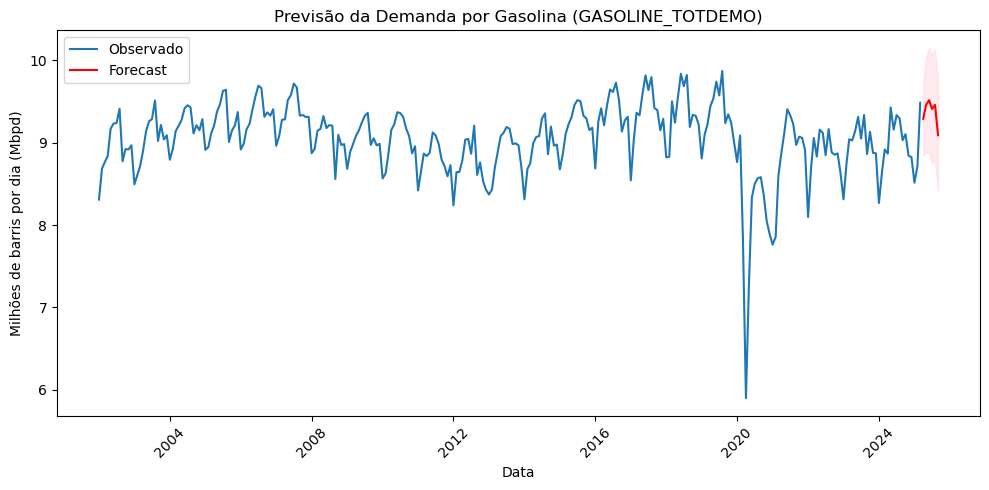

In [105]:
# Fazer previsão para os próximos 6 períodos (meses)
forecast, conf_int = modelo_sarima.predict(n_periods=6, return_conf_int=True)

# Criar índice de datas para os próximos 6 meses
ultimo_periodo = jodi_dataset.index[-1]
periodos_futuros = pd.date_range(start=ultimo_periodo + pd.offsets.MonthBegin(1), periods=6, freq='MS')

# Plotar dados históricos e previsão
plt.figure(figsize=(10, 5))
plt.plot(jodi_dataset.index, jodi_dataset['GASOLINE_TOTDEMO'], label='Observado')
plt.plot(periodos_futuros, forecast, label='Forecast', color='red')
plt.fill_between(periodos_futuros, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('Previsão da Demanda por Gasolina (GASOLINE_TOTDEMO)')
plt.xlabel('Data')
plt.ylabel('Milhões de barris por dia (Mbpd)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [106]:
# Criar DataFrame com os resultados
tabela_previsao = pd.DataFrame({
    'Data': periodos_futuros,
    'Previsão (Mbpd)': forecast,
    'IC Inferior': conf_int[:, 0],
    'IC Superior': conf_int[:, 1]
})

# Ajustar a formatação dos números para facilitar a visualização
tabela_previsao['Previsão (Mbpd)'] = tabela_previsao['Previsão (Mbpd)'].map(lambda x: f"{x:,.2f}")
tabela_previsao['IC Inferior'] = tabela_previsao['IC Inferior'].map(lambda x: f"{x:,.2f}")
tabela_previsao['IC Superior'] = tabela_previsao['IC Superior'].map(lambda x: f"{x:,.2f}")

# Preparar para Concatenar na Base Original
temp_dt_sarima = tabela_previsao.copy()



temp_dt_sarima.rename(columns={'Data Prevista': 'TIME_PERIOD', "Previsão (Mbpd)":"GASOLINE_TOTDEMO"}, inplace=True)
temp_dt_sarima['TIME_PERIOD'] = [
    '2025-04-01',
    '2025-05-01',
    '2025-06-01',
    '2025-07-01',
    '2025-08-01',
    '2025-09-01'
]

temp_dt_sarima = temp_dt_sarima[["TIME_PERIOD", "GASOLINE_TOTDEMO"]]
temp_dt_sarima["TIME_PERIOD"] = pd.to_datetime(temp_dt_sarima["TIME_PERIOD"])

# Exibir a tabela
tabela_previsao

,Data,Previsão (Mbpd),IC Inferior,IC Superior
2025-04-01,2025-04-01,9.29,8.85,9.73
2025-05-01,2025-05-01,9.46,8.88,10.04
2025-06-01,2025-06-01,9.52,8.88,10.15
2025-07-01,2025-07-01,9.41,8.75,10.07
2025-08-01,2025-08-01,9.46,8.79,10.13
2025-09-01,2025-09-01,9.09,8.41,9.77


### MODELO SARIMA - GASOLINA
A previsão da demanda por gasolina para os próximos seis meses indica uma leve alta no início do período, seguida por uma estabilização, com os valores permanecendo dentro de uma faixa historicamente consistente. Esse comportamento é compatível com a tendência observada durante a "driving season", que ocorre entre maio e setembro, quando o consumo de gasolina tende a aumentar em razão do maior deslocamento de veículos em viagens e atividades de lazer. A previsão oferece uma estimativa realista e alinhada ao padrão sazonal esperado, permitindo antecipar possíveis movimentos na demanda e auxiliar no planejamento do mercado de combustíveis.

### TABELA FINAL COM PREVISÕES


In [107]:
# Merging Estimações
project_data = pd.merge(
    temp_dt_arima,
    temp_dt_sarima,
    on='TIME_PERIOD',
    how='outer',
)



project_data['GASDIES_TOTDEMO'] = pd.to_numeric(project_data['GASDIES_TOTDEMO'], errors='coerce')
project_data['GASOLINE_TOTDEMO'] = pd.to_numeric(project_data['GASOLINE_TOTDEMO'], errors='coerce')

# Coeficientes do modelo
intercepto = modelo.params['const']
coef_gasdies = modelo.params['GASDIES_TOTDEMO']
coef_gasoline = modelo.params['GASOLINE_TOTDEMO']

# Calcular a previsão
project_data['CRUDEOIL_REFINOBS'] = (
    intercepto
    + coef_gasdies * project_data['GASDIES_TOTDEMO']
    + coef_gasoline * project_data['GASOLINE_TOTDEMO']
)

project_data

,TIME_PERIOD,GASDIES_TOTDEMO,GASOLINE_TOTDEMO,CRUDEOIL_REFINOBS
0,2025-04-01,3.99,9.29,15.774596
1,2025-05-01,4.05,9.46,16.015587
2,2025-06-01,4.07,9.52,16.100171
3,2025-07-01,4.08,9.41,15.963793
4,2025-08-01,4.09,9.46,16.031609
5,2025-09-01,4.09,9.09,15.559409


In [108]:
# Criando uma nova base para juntar as previsões
jodi_dataset_predictions = pd.concat([jodi_dataset_predictions, project_data], ignore_index=True)
jodi_dataset_predictions 
# Exportar essa Base para diretório desejado
jodi_dataset_predictions.to_csv("../../data/processed/jodi_dataset_predictions.csv")
